In [ ]:
Ахметов Артём
316 группа
Реализация k-means

In [299]:
from sklearn.datasets import make_blobs
X, y = make_blobs(n_samples=100,n_features=2,centers=3,random_state=0)

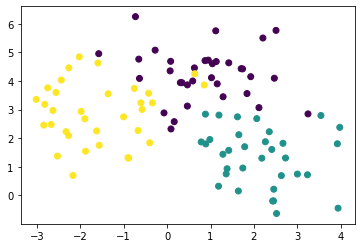

In [300]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.scatter(X[:, 0], X[:, 1], c=y)

In [301]:
import numpy as np

class KMeansMyImplementation:
    
    def __init__(self, n_clusters=8, random_state=None, init='k-means++', n_init=10, 
                 max_iter=300, tol=0.0001): # параметры как в sklearn, некоторые не реализовывал
        self.n_clusters = n_clusters
        self.random_state = random_state
        self.init=init # 'k-means++', 'random' or an ndarray
        self.n_init=n_init
        self.max_iter=max_iter
        self.tol=tol # пороговое отклонение
        
    def squared_dist(self, x, y): # квадрат расстояния между двумя объектами  
        return sum((x - y)**2)
    
    def dist(self, x, y): # расстояние между двумя объектами
        return sum((x - y)**2)**0.5
    
    def norm(self, x): # норма объекта
        return sum(x**2)**0.5
    
    def crit(self, new_centr, old_centr): # Сумма расстояний от центроидов на текущем шаге
        s = 0                             # до центроидов на предыдущем. Используется как
        for x in (new_centr - old_centr): # критерий завершения поиска центроидов
            s += self.norm(x)
        return s
    
    def get_centr(self, X, oldCentr): # "центр масс" объектов из одного кластера
        if len(X):
            return sum(X)/len(X)
        else:           # если в кластере отсутствуют объекты, возвращаем предыдущий "центр масс"
            return oldCentr
        
    def get_centrs(self, X, labels, centr): # центроиды кластеров
        # M - это список, i-м элементом которого является массив, состоящий 
        # из объектов, принадлежащих i-му кластеру
        M = [np.array([X[j] for j in range(len(X)) if labels[j] == i]) for i in range(self.n_clusters)]
        return np.array([self.get_centr(M[i], centr[i]) for i in range(self.n_clusters)])
    
    def find_centr(self, n, X): # поиск объекта, наиболее удаленного от первых n объектов,
        max_d = 0               # используется в k-means++
        for x in X:
            cur_norm = self.norm(np.array([self.dist(x, X[i]) for i in range(n)]))
            if max_d < cur_norm:
                max_d = cur_norm
                max_x = x
        return max_x
    
    def fit_predict(self, X):
        
        if self.n_init <= 0:
            raise ValueError("Invalid number of initializations."
                         "n_init=%d must be bigger than zero." % self.n_init)
        if self.max_iter <= 0:
            raise ValueError('Number of iterations should be a positive number,'
                         ' got %d instead' % self.max_iter)    
        if len(X) < self.n_clusters:
            raise ValueError("n_samples=%d should be >= n_clusters=%d" % (
            len(X), self.n_clusters))
        
        
        if type(self.init) == np.ndarray:
            if self.init.shape[0] != self.n_clusters:
                raise ValueError('The shape of the initial centers (%s) '
                                 'does not match the number of clusters %i'
                                 % (self.init.shape[0], self.n_clusters))
            if self.init.shape[1] != X.shape[1]:
                raise ValueError("The number of features of the initial centers %s "
                                 "does not match the number of features of the data %s."
                                 % (self.init.shape[1], X.shape[1]))
            self.labels_ = np.array([0] * len(X))
            old_centers = np.array([[0.0] * len(X[0])] * self.n_clusters)
            self.cluster_centers_ = self.init.copy()
            eps = self.tol * self.n_clusters
            self.n_iter_ = 0
            while self.n_iter_ < self.max_iter and self.crit(self.cluster_centers_, old_centers) > eps:
                self.n_iter_ += 1
                for i in range(self.n_clusters):
                    old_centers[i] = self.cluster_centers_[i].copy()
                for i in range(len(X)):
                    min_dist = self.dist(X[i], old_centers[0])
                    jmin = 0
                    for j in range(1, self.n_clusters):
                        if self.dist(X[i], old_centers[j]) < min_dist:
                            min_dist = self.dist(X[i], old_centers[j])
                            jmin = j
                    self.labels_[i] = jmin
                self.cluster_centers_ = self.get_centrs(X, self.labels_, old_centers).copy()
            self.inertia_ = 0
            for i in range(len(X)):
                self.inertia_ += self.squared_dist(X[i], self.cluster_centers_[self.labels_[i]])
            return self.labels_
        else:
            np.random.seed(self.random_state)
            inertia = [0] * self.n_init
            labels = np.array([[0] * len(X) for l in range(self.n_init)])
            cluster_centers = np.array([[[0.0] * len(X[0])] * self.n_clusters for l in range(self.n_init)])
            eps = self.tol * self.n_clusters
            n_iter = [0] * self.n_init
            for n_init in range(self.n_init):
                old_centers = np.array([[0.0] * len(X[0])] * self.n_clusters).copy()
                if self.init == 'k-means++':
                    cluster_centers[n_init][0] = X[np.random.randint(0,len(X))].copy()
                    for i in range(1, self.n_clusters):
                        cluster_centers[n_init][i] = self.find_centr(i, X).copy()       
                elif self.init == 'random':
                    for i in range(self.n_clusters):
                        cluster_centers[n_init][i] = X[np.random.randint(0,len(X))].copy()
                else:
                    raise ValueError("the init parameter for the k-means should "
                            "be 'k-means++' or 'random' or an ndarray, "
                            "'%s' (type '%s') was passed." % (self.init, type(self.init)))
                while n_iter[n_init] < self.max_iter and self.crit(cluster_centers[n_init], old_centers) > eps:
                    n_iter[n_init] += 1
                    for i in range(self.n_clusters):
                        old_centers[i] = cluster_centers[n_init][i].copy()
                    for i in range(len(X)):
                        min_dist = self.dist(X[i], old_centers[0])
                        jmin = 0
                        for j in range(1, self.n_clusters):
                            if self.dist(X[i], old_centers[j]) < min_dist:
                                min_dist = self.dist(X[i], old_centers[j])
                                jmin = j
                        labels[n_init][i] = jmin
                    cluster_centers[n_init] = self.get_centrs(X, labels[n_init], old_centers).copy()
                for i in range(len(X)):
                    inertia[n_init] += self.squared_dist(X[i], cluster_centers[n_init][labels[n_init][i]])
                    
            best_n_init = 0
            self.inertia_ = inertia[0]
            for n_init in range(1, self.n_init):
                if inertia[n_init] < self.inertia_:
                    self.inertia_ = inertia[n_init]
                    best_n_init = n_init
            
            self.cluster_centers_ = cluster_centers[best_n_init].copy()
            self.labels_ = labels[best_n_init].copy()
            self.n_iter_ = n_iter[best_n_init]
            return self.labels_
        
    def fit(self, X):
        
        if self.n_init <= 0:
            raise ValueError("Invalid number of initializations."
                         "n_init=%d must be bigger than zero." % self.n_init)
        if self.max_iter <= 0:
            raise ValueError('Number of iterations should be a positive number,'
                         ' got %d instead' % self.max_iter)    
        if len(X) < self.n_clusters:
            raise ValueError("n_samples=%d should be >= n_clusters=%d" % (
            len(X), self.n_clusters))
        
        if type(self.init) == np.ndarray:
            if self.init.shape[0] != self.n_clusters:
                raise ValueError('The shape of the initial centers (%s) '
                                 'does not match the number of clusters %i'
                                 % (self.init.shape[0], self.n_clusters))
            if self.init.shape[1] != X.shape[1]:
                raise ValueError("The number of features of the initial centers %s "
                                 "does not match the number of features of the data %s."
                                 % (self.init.shape[1], X.shape[1]))
            self.labels_ = np.array([0] * len(X))
            old_centers = np.array([[0.0] * len(X[0])] * self.n_clusters)
            self.cluster_centers_ = self.init.copy()
            eps = self.tol * self.n_clusters
            self.n_iter_ = 0
            while self.n_iter_ < self.max_iter and self.crit(self.cluster_centers_, old_centers) > eps:
                self.n_iter_ += 1
                for i in range(self.n_clusters):
                    old_centers[i] = self.cluster_centers_[i].copy()
                for i in range(len(X)):
                    min_dist = self.dist(X[i], old_centers[0])
                    jmin = 0
                    for j in range(1, self.n_clusters):
                        if self.dist(X[i], old_centers[j]) < min_dist:
                            min_dist = self.dist(X[i], old_centers[j])
                            jmin = j
                    self.labels_[i] = jmin
                self.cluster_centers_ = self.get_centrs(X, self.labels_, old_centers).copy()
            self.inertia_ = 0
            for i in range(len(X)):
                self.inertia_ += self.squared_dist(X[i], self.cluster_centers_[self.labels_[i]])
            return self.labels_
        else:
            np.random.seed(self.random_state)
            inertia = [0] * self.n_init
            labels = np.array([[0] * len(X) for l in range(self.n_init)])
            cluster_centers = np.array([[[0.0] * len(X[0])] * self.n_clusters for l in range(self.n_init)])
            eps = self.tol * self.n_clusters
            n_iter = [0] * self.n_init
            for n_init in range(self.n_init):
                old_centers = np.array([[0.0] * len(X[0])] * self.n_clusters).copy()
                if self.init == 'k-means++':
                    cluster_centers[n_init][0] = X[np.random.randint(0,len(X))].copy()
                    for i in range(1, self.n_clusters):
                        cluster_centers[n_init][i] = self.find_centr(i, X).copy()       
                elif self.init == 'random':
                    for i in range(self.n_clusters):
                        cluster_centers[n_init][i] = X[np.random.randint(0,len(X))].copy()
                else:
                    raise ValueError("the init parameter for the k-means should "
                            "be 'k-means++' or 'random' or an ndarray, "
                            "'%s' (type '%s') was passed." % (self.init, type(self.init)))
                while n_iter[n_init] < self.max_iter and self.crit(cluster_centers[n_init], old_centers) > eps:
                    n_iter[n_init] += 1
                    for i in range(self.n_clusters):
                        old_centers[i] = cluster_centers[n_init][i].copy()
                    for i in range(len(X)):
                        min_dist = self.dist(X[i], old_centers[0])
                        jmin = 0
                        for j in range(1, self.n_clusters):
                            if self.dist(X[i], old_centers[j]) < min_dist:
                                min_dist = self.dist(X[i], old_centers[j])
                                jmin = j
                        labels[n_init][i] = jmin
                    cluster_centers[n_init] = self.get_centrs(X, labels[n_init], old_centers).copy()
                for i in range(len(X)):
                    inertia[n_init] += self.squared_dist(X[i], cluster_centers[n_init][labels[n_init][i]])
                    
            best_n_init = 0
            self.inertia_ = inertia[0]
            for n_init in range(1, self.n_init):
                if inertia[n_init] < self.inertia_:
                    self.inertia_ = inertia[n_init]
                    best_n_init = n_init
            
            self.cluster_centers_ = cluster_centers[best_n_init].copy()
            self.labels_ = labels[best_n_init].copy()
            self.n_iter_ = n_iter[best_n_init]
        return self
        
    def predict(self, X):
        self.labels_ = np.array([0] * len(X))
        for i in range(len(X)):
            min_dist = self.dist(X[i], self.cluster_centers_[0])
            jmin = 0
            for j in range(1, self.n_clusters):
                if self.dist(X[i], self.cluster_centers_[j]) < min_dist:
                    min_dist = self.dist(X[i], self.cluster_centers_[j])
                    jmin = j
            self.labels_[i] = jmin
        return self.labels_

In [302]:
kmns = KMeansMyImplementation(n_clusters=3, random_state=0)

In [303]:
pred = kmns.fit_predict(X)
pred

array([0, 1, 0, 2, 2, 1, 2, 2, 0, 1, 1, 1, 0, 1, 2, 0, 2, 2, 2, 2, 2, 2,
       2, 2, 0, 0, 0, 0, 2, 2, 1, 0, 0, 1, 2, 1, 1, 0, 0, 2, 2, 0, 0, 1,
       1, 1, 0, 0, 2, 2, 1, 0, 1, 0, 2, 2, 0, 0, 1, 0, 0, 2, 2, 2, 2, 0,
       1, 2, 0, 1, 2, 0, 2, 0, 1, 1, 1, 1, 2, 0, 1, 1, 0, 1, 1, 1, 1, 1,
       0, 1, 0, 0, 2, 2, 2, 2, 1, 1, 2, 2])

In [304]:
kmns.inertia_

167.75875127963712

In [305]:
kmns.n_iter_

8

In [306]:
kmns.cluster_centers_

array([[ 2.2427373 ,  1.30652003],
       [ 0.9801637 ,  4.30837857],
       [-1.5510878 ,  2.88827923]])

In [307]:
kmns.labels_

array([0, 1, 0, 2, 2, 1, 2, 2, 0, 1, 1, 1, 0, 1, 2, 0, 2, 2, 2, 2, 2, 2,
       2, 2, 0, 0, 0, 0, 2, 2, 1, 0, 0, 1, 2, 1, 1, 0, 0, 2, 2, 0, 0, 1,
       1, 1, 0, 0, 2, 2, 1, 0, 1, 0, 2, 2, 0, 0, 1, 0, 0, 2, 2, 2, 2, 0,
       1, 2, 0, 1, 2, 0, 2, 0, 1, 1, 1, 1, 2, 0, 1, 1, 0, 1, 1, 1, 1, 1,
       0, 1, 0, 0, 2, 2, 2, 2, 1, 1, 2, 2])

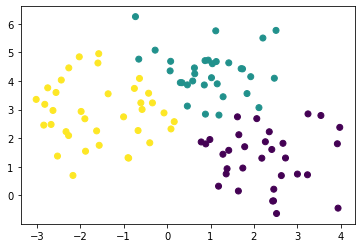

In [308]:
plt.scatter(X[:, 0], X[:, 1], c=kmns.labels_)

In [309]:
from sklearn.cluster import KMeans
a = KMeans(n_clusters=3, random_state=0)
pred2 = a.fit_predict(X)

In [310]:
a.inertia_

167.75875127963718

In [311]:
a.n_iter_

4

In [312]:
a.cluster_centers_

array([[-1.5510878 ,  2.88827923],
       [ 2.2427373 ,  1.30652003],
       [ 0.9801637 ,  4.30837857]])

In [313]:
a.labels_

array([1, 2, 1, 0, 0, 2, 0, 0, 1, 2, 2, 2, 1, 2, 0, 1, 0, 0, 0, 0, 0, 0,
       0, 0, 1, 1, 1, 1, 0, 0, 2, 1, 1, 2, 0, 2, 2, 1, 1, 0, 0, 1, 1, 2,
       2, 2, 1, 1, 0, 0, 2, 1, 2, 1, 0, 0, 1, 1, 2, 1, 1, 0, 0, 0, 0, 1,
       2, 0, 1, 2, 0, 1, 0, 1, 2, 2, 2, 2, 0, 1, 2, 2, 1, 2, 2, 2, 2, 2,
       1, 2, 1, 1, 0, 0, 0, 0, 2, 2, 0, 0], dtype=int32)

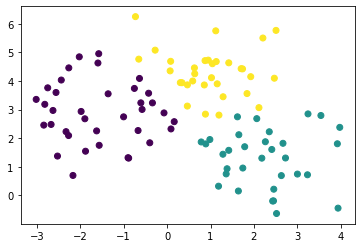

In [314]:
plt.scatter(X[:, 0], X[:, 1], c=a.labels_)

In [ ]:
""" 
    0. Логичное упорядочение кластеров:
    Кластеры можно упорядочить по близости объектов одного кластера
и отдаленности от объектов других кластеров, т.е.первый кластер - 
в котором объекты находятся на максимально близком расстоянии друг 
от друга и максимально отдалены от объектов других кластеров, 
последний кластер - в котором наоборот. В терминах визуализированных
матриц попарных расстояний это значит, что первые диагональные 
квадратики выделяются максимально сильно, а последние слабо.
    Также можно упорядочить по количеству объектов в кластерах.
    
    1. Зависимость от стратегии начальной инициализации:
    При различных значениях random_state могут получаться разные
ответы, потому что в зависимости от того, какие объекты будут
выбраны за изначальные центроиды, кластеры будут иметь разную
нумерацию. Например: рассмотрим случай трёх кластеров (как
на картинке выше) и пусть фиолетовому цвету соответствует
первый кластер, жёлтому - второй и голубому - третий, если 
при значении random_state1 за изначальный центроид первого 
кластера выбран объект левого кластера (остальные изначальные 
центроиды допустим оказались в других кластерах), то в итоге левый 
кластер (на этом рисунке) окажется раскрашенным в фиолетовый цвет; 
а если же при random_state2 выбрали за изначальный центроид первого 
кластера объект правого нижнего кластера (на этом рисунке), то 
фиолетовым в итоге окажется правый нижний кластер. При использовании 
метода k-means++, изначальные центроиды, скорее всего, будут оказываться 
в разных кластерах, а при рандомной инициализации центроидов, может 
оказаться так, что все три центроида окажутся в одном кластере.
    Если же нумерацию кластеров не считать за различие, 
то при разных значениях random_state ответы будут получаться
практически одинаковыми. Различия в этом случае обусловлены тем, что
пересчёт центроидов может завершиться при различных значениях
функции crit(...) (пишу в терминах своего кода). Например, в одном
случае эта функция имеет нулевое значение, в другом ненулевое, но
меньшее, чем eps - очевидно, что в этом случае ответы будут немного 
разные.

    2. k-means будет плохо работать работать в случаях, когда:
    - данные имеют выбросы
    - кластеры не имеют шаровую форму
    
    3. Стратегия выбора числа кластеров:
    Нужно выбрать такое число кластеров, при котором объекты
из одного кластера максимально близки друг к другу и максимально
далеки от объектов из других кластеров. Это делается следующим
образом.
    Можно построить для различных n_clusters матрицы попарных
расстояний, сгруппированных по кластерам объектов, сделать их 
визуализацию (это сделано ниже, далее говорю в терминах этой 
визуализации). Выберем такое n_clusters, при котором диагональные
квадраты будут максимально белыми и минимально красными, а всё
остальное пространство максимально красным и минимально белым.
Короче говоря, диагональные квадраты должны максимально сильно
вылеляться. Из этой визуализации хорошо видно, что лучшее значение
числа кластеров - 3, что и соответствует действительности.
    
    4. O(n_init*max_iter*len(X)*n_clusters)
    
    5. Визуализация матрицы попарных расстояний - сделано ниже.
    
"""

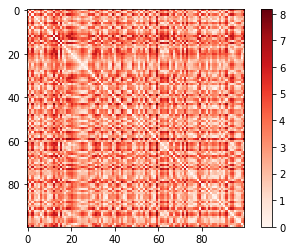

In [289]:
from sklearn.metrics import pairwise_distances # без упорядочения по кластерам
DM = pairwise_distances(X)
plt.imshow(DM, cmap='Reds')
plt.colorbar()
plt.show()

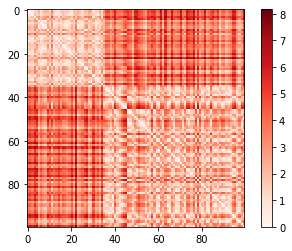

In [288]:
kmns2 = KMeansMyImplementation(n_clusters=2, random_state=0) #k = 2
kmns2.fit(X)
X_sorted2 = []
for i in range(2):
    for j in range(len(X)):
        if kmns2.labels_[j] == i:
            X_sorted2.append(X[j])
DM_sorted2 = pairwise_distances(X_sorted2) 
plt.imshow(DM_sorted2, cmap='Reds')
plt.colorbar()
plt.show()

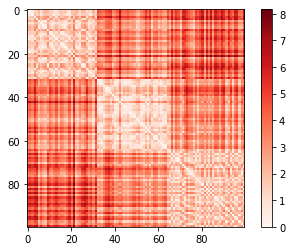

In [290]:
kmns3 = KMeansMyImplementation(n_clusters=3, random_state=0) #k = 3
kmns3.fit(X)
kmns3.labels_
X_sorted3 = []
for i in range(3):
    for j in range(len(X)):
        if kmns3.labels_[j] == i:
            X_sorted3.append(X[j])
DM_sorted3 = pairwise_distances(X_sorted3) 
plt.imshow(DM_sorted3, cmap='Reds')
plt.colorbar()
plt.show()

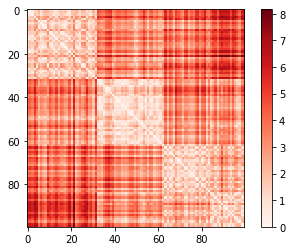

In [291]:
kmns4 = KMeansMyImplementation(n_clusters=4, random_state=0) #k = 4
kmns4.fit(X)
kmns4.labels_
X_sorted4 = []
for i in range(4):
    for j in range(len(X)):
        if kmns4.labels_[j] == i:
            X_sorted4.append(X[j])
DM_sorted4 = pairwise_distances(X_sorted4) 
plt.imshow(DM_sorted4, cmap='Reds')
plt.colorbar()
plt.show()

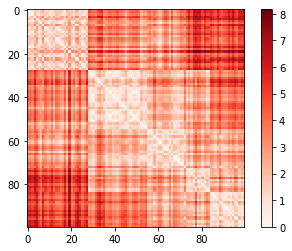

In [292]:
kmns5 = KMeansMyImplementation(n_clusters=5, random_state=0) #k = 5
kmns5.fit(X)
kmns5.labels_
X_sorted5 = []
for i in range(5):
    for j in range(len(X)):
        if kmns5.labels_[j] == i:
            X_sorted5.append(X[j])
DM_sorted5 = pairwise_distances(X_sorted5) 
plt.imshow(DM_sorted5, cmap='Reds')
plt.colorbar()
plt.show()